In [7]:
%matplotlib notebook

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime as dt

In [9]:
data_path = r'C:\Users\apbarret\Documents\data\SnowOnSeaIce'
reanalysis_path = os.path.join(data_path, 'arctic_ocean_reanalysis_prectot_nh50km.csv')
bogd_path = os.path.join(data_path, 'NPSNOW', 'bogdanova2002', 'bogdanova2002_table4.xlsx')
yang_path = os.path.join(r'C:\Users\apbarret\Documents\data\Arctic_precip', r'NPP-yang_copy_apb.xls')

In [10]:
def read_yang(filepath):
    df = pd.read_excel(filepath, sheet_name='monthly-all', header=0, skiprows=[1,2,3], 
                       na_values='-', usecols=14)
    df = df.dropna(how='all')
    
    yyyy = 1900 + df['YY'].values.astype(int)
    mm = df['MM'].values.astype(int)
    df.index = [dt.datetime(y,m,1) for y, m in zip(yyyy, mm)]
    
    return df

In [11]:
def read_reanalysis(filepath):
    df = pd.read_csv(filepath, header=0, parse_dates=True, index_col=0)
    return df

In [12]:
reanalysis = read_reanalysis(reanalysis_path)
reanalysis.head()

,CFSR,ERAI,MERRA2,MERRA,JRA55,ERA5
time,,,,,,
1981-01-01,306.881781,223.988853,304.862273,207.681740,197.315406,NaN
1982-01-01,294.567532,211.700976,283.501657,202.292063,189.330198,NaN
1983-01-01,296.968322,212.625638,278.575292,205.876794,186.802741,NaN
1984-01-01,313.253801,228.748112,286.883097,213.843629,198.726972,NaN
1985-01-01,293.139858,206.497195,262.488245,198.836162,181.875523,NaN


In [13]:
def read_bogdanova(filepath):
    df = pd.read_excel(filepath, sheet_name='Sheet1', header=0)
    df.index = [dt.datetime(y,1,1) for y in df.Year]
    return df

In [14]:
bogd_annual = read_bogdanova(bogd_path)
bogd_annual.head()

,Year,n,ta,Uh,Dp,Parch,"P""",P,"P/P""",deltaP,"Parch - P""","P""f1 + P""f2","(P""f1+P""f2)/P"""
1956-01-01,1956,16,-15.7,5.5,233.5,158.2,136.7,127.0,0.93,17.50,21.5,-75.0,0.55
1957-01-01,1957,20,-16.4,6.1,181.0,177.7,160.1,164.5,1.03,10.68,17.6,-81.8,0.51
1958-01-01,1958,24,-18.4,4.7,227.0,149.2,129.7,159.7,1.23,11.45,19.6,-35.0,0.27
1962-01-01,1962,23,-15.8,5.5,230.5,121.6,101.7,125.1,1.23,15.25,19.9,-39.7,0.39
1963-01-01,1963,24,-18.4,4.5,239.5,125.9,107.1,150.1,1.40,18.15,18.8,-29.6,0.28


In [15]:
yang = read_yang(yang_path)
yang.head()

,NP,YY,MM,ND,Lat,Lon,Tmn,Ug,DP,Dtc,snow%,Pg,windC,traceC,Pc
1989-01-01,31.0,89.0,1.0,31.0,74.51,-150.67,-31.2,4.7,5.0,25.0,100.0,2.0,1.5,2.5,6.0
1989-02-01,31.0,89.0,2.0,28.0,74.70,-147.57,-20.3,4.7,19.0,8.0,100.0,21.3,20.3,0.8,42.4
1989-03-01,31.0,89.0,3.0,31.0,75.30,-146.08,-28.8,3.9,6.0,24.0,100.0,4.3,4.3,2.4,11.0
1989-04-01,31.0,89.0,4.0,30.0,75.48,-146.26,-22.2,3.6,9.0,20.0,100.0,5.1,2.6,2.0,9.7
1989-05-01,31.0,89.0,5.0,31.0,75.46,-146.25,-11.2,3.2,18.0,12.0,100.0,7.4,2.9,1.2,11.5


In [16]:
table = pd.concat([yang[yang['NP'] == 31]['Pc'], 
                   yang[yang['NP'] == 30]['Pc'],
                   yang[yang['NP'] == 29]['Pc'],
                   yang[yang['NP'] == 28]['Pc'],
                   yang[yang['NP'] == 27]['Pc'],
                   yang[yang['NP'] == 26]['Pc'],
                   yang[yang['NP'] == 25]['Pc'],
                   yang[yang['NP'] == 24]['Pc'],
                   yang[yang['NP'] == 22]['Pc'],], 
                  axis=1, keys=['31','30','29','28','27','26','25','24','22']) 
yang_month = table.mean(axis=1)['1979':]
yang_annual = yang_month.groupby(yang_month.index.year).sum(min_count=12)
yang_annual.index = [dt.datetime(y,1,1) for y in yang_annual.index]
yang_annual

1979-01-01    276.20
1980-01-01    259.80
1981-01-01    226.85
1982-01-01    263.35
1983-01-01    341.75
1984-01-01    251.55
1985-01-01    146.90
1986-01-01    160.75
1987-01-01       NaN
1988-01-01    283.10
1989-01-01    291.45
1990-01-01    208.45
1991-01-01       NaN
dtype: float64

In [17]:
dummy = """r,g,b,c,m,y,k,RGB Hexadecimal,reanalysis
    226, 31, 38,  0,86.28,83.19,11.37,  E21F26,  MERRA2
    246, 153, 153,  0,37.8,37.8,3.53,  F69999,  MERRA
    41, 95, 138,  70.29,31.16,0,45.88,  295F8A,  ERAI
    95, 152, 198,  52.02,23.23,0,22.35,  5F98C6,  ERA5
    175, 203, 227,  22.91,10.57,0,10.98,  AFCBE3,  ERA40
    114, 59, 122,  6.56,51.64,0,52.16,  723B7A,  JRA55
    173, 113, 181,  4.42,37.57,0,29.02,  AD71B5,  JRA-55C or JRA-55 AMIP
    214, 184, 218,  1.83,15.6,0,14.51,  D6B8DA,  JRA-25
    245, 126, 32,  0,48.57,86.94,3.92,  F57E20,  NCEP-R1
    253, 191, 110,  0,24.51,56.52,0.78,  FDBF6E,  NCEP-R2
    236, 0, 140,  0,100,40.68,7.45,  EC008C,  20CRv2c
    247, 153, 209,  0,38.06,15.38,3.14,  F799D1,  20CRv2
    0, 174, 239,  100,27.2,0,6.27,  00AEEF,  CERA-20C
    96, 200, 232,  58.62,13.79,0,9.02,  60C8E8,  ERA-20C
    52, 160, 72,  67.5,0,55,37.25,  34A048,  CFSR
    179, 91, 40,  0,49.16,77.65,29.8,  B35B28,  REM
    255,215,0,  0,15.69,100,0,  FFD700,  Other
    0, 0, 0,  0,0,0,100,  000000,  Obs
    119, 119, 119,  0,0,0,53.33,  777777,  Other Obs"""

reanalysis_color = {}
for line in dummy.split('\n')[1:]:
    v, k = line.split(',')[-2:]
    reanalysis_color[k.strip()] = '#'+v.strip()


In [18]:
reanalysis_color['MERRA']

'#F69999'

<IPython.core.display.Javascript object>


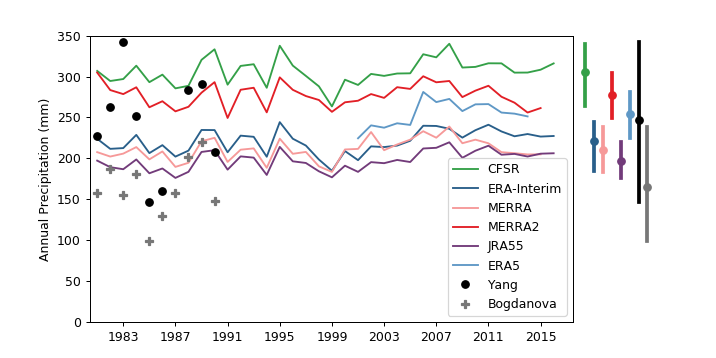

In [23]:
fig, ax = plt.subplots(figsize=(8,4))

ax.set_ylim(0,350)
ax.set_xlim(dt.datetime(1980,6,1),dt.datetime(2017,6,30))

#reanalysis.plot(ax=ax)
#yang_annual.plot(ax=ax)
#bogd_annual['P'].plot(ax=ax)
ax.plot(reanalysis.index, reanalysis.CFSR, label='CFSR', color=reanalysis_color['CFSR'])
ax.plot(reanalysis.index, reanalysis.ERAI, label='ERA-Interim', color=reanalysis_color['ERAI'])
ax.plot(reanalysis.index, reanalysis.MERRA, label='MERRA', color=reanalysis_color['MERRA'])
ax.plot(reanalysis.index, reanalysis.MERRA2, label='MERRA2', color=reanalysis_color['MERRA2'])
ax.plot(reanalysis.index, reanalysis.JRA55, label='JRA55', color=reanalysis_color['JRA55'])
ax.plot(reanalysis.index, reanalysis.ERA5, label='ERA5', color=reanalysis_color['ERA5'])

ax.plot(yang_annual.index, yang_annual, 'o', label='Yang', color=reanalysis_color['Obs'])
ax.plot(bogd_annual.index, bogd_annual['P'], 'P', label='Bogdanova', color=reanalysis_color['Other Obs'])

handles, labels = ax.get_legend_handles_labels() # get handles and labels to plot ranges
colors = {key: value.get_color() for key, value in zip(labels, handles)}
ax.legend()

ax.set_ylabel('Annual Precipitation (mm)')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
lax = plt.axes([0.81, 0.1, 0.1, 0.8], frame_on=False)
lax.set_xlim(-0.5,7.5)
lax.set_ylim(0,350)

lax.set_yticklabels([])
lax.set_xticklabels([])
lax.set_yticks([])
lax.set_xticks([])

def plot_range(x, ymin, ymax, yav, c, ax):
    ax.plot([x,x], [ymin,ymax], lw=3, color=c)
    ax.plot(x, yav, 'o', color=c)

plot_range(0., reanalysis.CFSR.min(), reanalysis.CFSR.max(), reanalysis.CFSR.mean(),
           colors['CFSR'], lax)
plot_range(1., reanalysis.ERAI.min(), reanalysis.ERAI.max(), reanalysis.ERAI.mean(),
           colors['ERA-Interim'], lax)
plot_range(2, reanalysis.MERRA.min(), reanalysis.MERRA.max(), reanalysis.MERRA.mean(),
           colors['MERRA'], lax)
plot_range(3, reanalysis.MERRA2.min(), reanalysis.MERRA2.max(), reanalysis.MERRA2.mean(),
           colors['MERRA2'], lax)
plot_range(4, reanalysis.JRA55.min(), reanalysis.JRA55.max(), reanalysis.JRA55.mean(),
           colors['JRA55'], lax)
plot_range(5, reanalysis.ERA5.min(), reanalysis.ERA5.max(), reanalysis.ERA5.mean(),
           colors['ERA5'], lax)

plot_range(6, yang_annual.min(), yang_annual.max(), yang_annual.mean(),
           colors['Yang'], lax)
plot_range(7, bogd_annual['P'].min(), bogd_annual['P'].max(), bogd_annual['P'].mean(),
           colors['Bogdanova'], lax)

fig.savefig('annual_precipitation_reanalysis_with_obs.png')

In [75]:
import numpy as np 
delta_lon = 0.66
RADIUS_EARTH = 6371.

def resolution(delta_lon, at_latitude=0.):
    return delta_lon * 2. * np.pi * RADIUS_EARTH * np.cos(np.radians(at_latitude)) / 360.

In [81]:
delta_lon = {'MERRA': 0.666,
             'MERRA2': 0.625,
             'NCEP1': 1.9,
             'NCEP2': 2.5,
             'CFSRv2': 0.5,
             'CFSR': 0.3,
             'ERA-40': 1.125,
             'ERA-Interim': 0.703125,
             'ERA5': 360./1440.,
             'JRA55': 0.5625,
             'JRA25': 1.125}

for key in delta_lon.keys():
    print ('{:12s} {:2.0f}'.format(key, resolution(delta_lon[key], at_latitude=60.) ))

MERRA        37
MERRA2       35
NCEP1        106
NCEP2        139
CFSRv2       28
CFSR         17
ERA-40       63
ERA-Interim  39
ERA5         14
JRA55        31
JRA25        63


In [78]:
360./640.

0.5625